In [ ]:
from tqdm import tqdm
import os
import time
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torch.optim as optim

from comet_ml import Experiment
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss


import albumentations as A
from albumentations import Compose, HorizontalFlip

import warnings
warnings.simplefilter("ignore")

# Definizione classe BratsDataset per collezzionare il dataset per training e validazione

In [ ]:
class BratsDataset(Dataset):
    def __init__(self, df: pd.DataFrame,  is_resize: bool=False):
        self.df = df
        self.augmentations = get_augmentations()
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        self.is_resize = is_resize
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        id_ = self.df.loc[idx, 'Brats20ID']
        level = self.df.loc[idx,'level']
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]
        # load all modalities
        images = []
        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)
            
            if self.is_resize:
                img = self.resize(img)
    
            img = self.normalize(img)
                        
            images.append(img)
            
        img = np.stack(images)

        mask_path =  os.path.join(root_path, id_ + "_seg.nii")
        mask = self.load_img(mask_path)

        if self.is_resize:
            mask = self.resize(mask)
            mask = np.clip(mask.astype(np.uint8), 0, 1).astype(np.float32)
            mask = np.clip(mask, 0, 1)
        mask = self.preprocess_mask_labels(mask,level)

        augmented = self.augmentations(image=img.astype(np.float32), 
                                       mask=mask.astype(np.float32))

        img = augmented['image']
        mask = augmented['mask']


        return {
            "Id": id_,
            "image": img,
            "mask": mask,
            "level" : level
        }
    
    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)
    
    def resize(self, data: np.ndarray):
        data = resize(data, (78, 120, 120), preserve_range=True)
        return data
    
    def preprocess_mask_labels(self, mask: np.ndarray, level):

        mask_WT = mask.copy()
        mask_WT[mask_WT == 1] = 1
        mask_WT[mask_WT == 2] = 1
        mask_WT[mask_WT == 4] = 1

        mask_TC = mask.copy()
        mask_TC[mask_TC == 1] = 1
        mask_TC[mask_TC == 2] = 0
        mask_TC[mask_TC == 4] = 1

        mask_ET = mask.copy()
        mask_ET[mask_ET == 1] = 0
        mask_ET[mask_ET == 2] = 0
        mask_ET[mask_ET == 4] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET])

        return mask

In [ ]:
class GlobalConfig:
    root_dir = '../input/brats20-dataset-training-validation'
    train_root_dir = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    test_root_dir = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
    path_to_csv = './train_data.csv'
    seed = 55
    
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = GlobalConfig()
seed_everything(config.seed)

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

In [ ]:
def get_augmentations():
    list_transforms = []
    
    list_trfms = Compose(list_transforms)
    return list_trfms


def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    batch_size: int = 1,
    num_workers: int = 4,
):
    '''Returns: dataloader for the model training'''
    df = pd.read_csv(path_to_csv)
    
    dataset = dataset(df)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True,   
    )
    return dataloader

In [ ]:
# DataLoaders di training validation e testing
# Il progetto è stato runnato su kaggle, una piattaforma che permette di integrare dataset presenti sulla piattaforma in modo molto agile
# In particolare sono stati usati i csv di training per considerare una porzione del nostro dataset e considerare
# la parte riamnente per la validazione

train_dl = get_dataloader(dataset=BratsDataset, path_to_csv='/kaggle/input/train-brats2020/train_data.csv', batch_size = 2,num_workers = 4)
val_dl = get_dataloader(dataset=BratsDataset, path_to_csv='val.csv', batch_size = 1, num_workers = 0)
test_dl = get_dataloader(dataset=BratsDataset, path_to_csv='/kaggle/input/test-brats2020/test_data.csv', batch_size = 2, num_workers = 0)

# Definizione funzioni di loss : Dice & BCE

In [ ]:

class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score
        
        
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        
        return bce_loss, dice_loss, bce_loss + dice_loss
    

# Definizione struttura della rete neurale Unet encoder

In [ ]:
class UNet(nn.Module):
    
    def __init__(self, num_classes, in_channels=1, initial_filter_size=64, kernel_size=3, do_instancenorm=True):
        super().__init__()

        self.contr_1_1 = self.contract(in_channels, initial_filter_size, kernel_size, instancenorm=do_instancenorm)
        self.contr_1_2 = self.contract(initial_filter_size, initial_filter_size, kernel_size, instancenorm=do_instancenorm)
        self.pool = nn.MaxPool2d(2, stride=2)

        self.contr_2_1 = self.contract(initial_filter_size, initial_filter_size*2, kernel_size, instancenorm=do_instancenorm)
        self.contr_2_2 = self.contract(initial_filter_size*2, initial_filter_size*2, kernel_size, instancenorm=do_instancenorm)
        # self.pool2 = nn.MaxPool2d(2, stride=2)

        self.contr_3_1 = self.contract(initial_filter_size*2, initial_filter_size*2**2, kernel_size, instancenorm=do_instancenorm)
        self.contr_3_2 = self.contract(initial_filter_size*2**2, initial_filter_size*2**2, kernel_size, instancenorm=do_instancenorm)
        # self.pool3 = nn.MaxPool2d(2, stride=2)

        self.contr_4_1 = self.contract(initial_filter_size*2**2, initial_filter_size*2**3, kernel_size, instancenorm=do_instancenorm)
        self.contr_4_2 = self.contract(initial_filter_size*2**3, initial_filter_size*2**3, kernel_size, instancenorm=do_instancenorm)
        # self.pool4 = nn.MaxPool2d(2, stride=2)

        self.center = nn.Sequential(
            nn.Conv2d(initial_filter_size*2**3, initial_filter_size*2**4, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(initial_filter_size*2**4, initial_filter_size*2**4, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(initial_filter_size*2**4, initial_filter_size*2**3, 2, stride=2),
            nn.ReLU(inplace=True),
        )

        self.expand_4_1 = self.expand(initial_filter_size*2**4, initial_filter_size*2**3)
        self.expand_4_2 = self.expand(initial_filter_size*2**3, initial_filter_size*2**3)
        self.upscale4 = nn.ConvTranspose2d(initial_filter_size*2**3, initial_filter_size*2**2, kernel_size=2, stride=2)

        self.expand_3_1 = self.expand(initial_filter_size*2**3, initial_filter_size*2**2)
        self.expand_3_2 = self.expand(initial_filter_size*2**2, initial_filter_size*2**2)
        self.upscale3 = nn.ConvTranspose2d(initial_filter_size*2**2, initial_filter_size*2, 2, stride=2)

        self.expand_2_1 = self.expand(initial_filter_size*2**2, initial_filter_size*2)
        self.expand_2_2 = self.expand(initial_filter_size*2, initial_filter_size*2)
        self.upscale2 = nn.ConvTranspose2d(initial_filter_size*2, initial_filter_size, 2, stride=2)

        self.expand_1_1 = self.expand(initial_filter_size*2, initial_filter_size)
        self.expand_1_2 = self.expand(initial_filter_size, initial_filter_size)
        # Output layer for segmentation
        self.final = nn.Conv2d(initial_filter_size, num_classes, kernel_size=1)  # kernel size for final layer = 1, see paper
        
        self.softmax = torch.nn.Softmax2d()

        # Output layer for "autoencoder-mode"
        self.output_reconstruction_map = nn.Conv2d(initial_filter_size, out_channels=1, kernel_size=1)

    @staticmethod
    def contract(in_channels, out_channels, kernel_size=3, instancenorm=True):
        if instancenorm:
            layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.LeakyReLU(inplace=True))
        else:
            layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
                nn.LeakyReLU(inplace=True))
        return layer

    @staticmethod
    def expand(in_channels, out_channels, kernel_size=3):
        layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            nn.LeakyReLU(inplace=True),
            )
        return layer

    @staticmethod
    def center_crop(layer, target_width, target_height):
        batch_size, n_channels, layer_width, layer_height = layer.size()
        xy1 = (layer_width - target_width) // 2
        xy2 = (layer_height - target_height) // 2
        return layer[:, :, xy1:(xy1 + target_width), xy2:(xy2 + target_height)]

    def forward(self, x, enable_concat=True, print_layer_shapes=False):
        concat_weight = 1
        if not enable_concat:
            concat_weight = 0

        contr_1 = self.contr_1_2(self.contr_1_1(x))
        pool = self.pool(contr_1)

        contr_2 = self.contr_2_2(self.contr_2_1(pool))
        pool = self.pool(contr_2)

        contr_3 = self.contr_3_2(self.contr_3_1(pool))
        pool = self.pool(contr_3)

        contr_4 = self.contr_4_2(self.contr_4_1(pool))
        pool = self.pool(contr_4)

        center = self.center(pool)

        crop = self.center_crop(contr_4, center.size()[2], center.size()[3])
        concat = torch.cat([center, crop*concat_weight], 1)

        expand = self.expand_4_2(self.expand_4_1(concat))
        upscale = self.upscale4(expand)

        crop = self.center_crop(contr_3, upscale.size()[2], upscale.size()[3])
        concat = torch.cat([upscale, crop*concat_weight], 1)

        expand = self.expand_3_2(self.expand_3_1(concat))
        upscale = self.upscale3(expand)

        crop = self.center_crop(contr_2, upscale.size()[2], upscale.size()[3])
        concat = torch.cat([upscale, crop*concat_weight], 1)

        expand = self.expand_2_2(self.expand_2_1(concat))
        upscale = self.upscale2(expand)

        crop = self.center_crop(contr_1, upscale.size()[2], upscale.size()[3])
        concat = torch.cat([upscale, crop*concat_weight], 1)

        expand = self.expand_1_2(self.expand_1_1(concat))

        if enable_concat:
            output = self.final(expand)
        if not enable_concat:
            output = self.output_reconstruction_map(expand)

        return output

# Definizione classe di Training con optimizer e salvataggio checkpoint per testing

In [ ]:
class UNetExperiment():
    
  """

  Questa classe è stata scritta per rendere il processo di training parametrico e 
  revisionabile in fase di training, così facendo abbiamo potuto osservare l'andamento della loss
  e fare considerazioni sui parametri della rete e sui parametri di training


  """

    def setup(self,device, train_dl, val_dl, test_dl, num_classes, 
              in_channels, filter_size, kernel_size, learning_rate):
        
        self.device = torch.device(device if torch.cuda.is_available() else "cpu")

        self.train_data_loader = train_dl
        self.val_data_loader = val_dl
        self.test_data_loader = test_dl
        
        self.model = UNet(num_classes= num_classes, 
                          in_channels= in_channels,
                          initial_filter_size= filter_size,
                          kernel_size= kernel_size
                         )

        self.model.to(self.device)
        
        self.loss = BCEDiceLoss()
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min')
        
   
    def train(self, epoches):
       
        data = None
        batch_counter = 0
        
        for epoch in range(epoches):
            
            self.model.train()
            
            for data_batch in self.train_data_loader:

                self.optimizer.zero_grad()

                data = data_batch['image'].float().to(self.device)
                target = data_batch['mask'].float().to(self.device)

                pred = self.model(data)

                logits = F.softmax(pred, dim=1)  # We calculate a softmax, because our SoftDiceLoss expects that as an input. The CE-Loss does the softmax internally.

                loss = self.loss(logits,target)[2]

                loss.backward()

                self.optimizer.step()

                # Some logging 
                if (batch_counter % 975 ) == 0:
                    print(f'Epoch: {epoch} Loss train:',loss)
                    
                batch_counter += 1
               
            self.save(epoch)
            self.validate(epoch)
            
        assert data is not None, 'data is None. Please check if your dataloader works properly'
    
    def save(self,epoch):
        path = f'/kaggle/working/epoch{epoch}'
        os.makedirs(path, exist_ok = True) 
        torch.save(self.model.state_dict(), os.path.join(path,'model.pth'))
        
    def load(self,epoch):
        path = f'/kaggle/working/epoch{epoch}/model.pth'
        self.model.load_state_dict(torch.load(path))
        return self.model
    
    def validate(self,epoch):
        
        self.model.eval()

        data = None
        loss_list = []

        with torch.no_grad():
            for data_batch in self.val_data_loader:
                data = data_batch['image'].float().to(self.device)
                target = data_batch['mask'].float().to(self.device)

                pred = self.model(data)
                logits = F.softmax(pred, dim=1)  # We calculate a softmax, because our SoftDiceLoss expects that as an input. The CE-Loss does the softmax internally.
                elem = np.array([self.loss(logits,target)[0].item(), 
                        self.loss(logits,target)[1].item(), 
                        self.loss(logits,target)[2].item()])
                loss_list.append(elem)

        assert data is not None, 'data is None. Please check if your dataloader works properly'
        loss_list = np.array(loss_list)
        
        avg_losses = loss_list.mean( axis=0 )
        print(f'epoch {epoch} bce val loss {avg_losses[0]}')
        print(f'epoch {epoch} dice val loss {avg_losses[1]}')
        print(f'epoch {epoch} combined val loss {avg_losses[2]}')
        
    

In [ ]:
ue = UNetExperiment()
num_classes = 3
in_channels = 4
filter_size = 6
kernel_size = 3
learning_rate = 1e-3
device = 'cuda'
ue.setup(device, train_dl, val_dl, test_dl, num_classes, 
         in_channels, filter_size, kernel_size, learning_rate )

ue.train(100)

In [ ]:
m = torch.jit.script(ue.model)
path = 'pretrained_unet2d'
m.save(path)

# Fase di loading modello pretrainato e testing su visualizzazione

In [ ]:
path = 'pretrained_unet2d'

net = torch.jit.load(path)

In [ ]:
val_dl = 

In [ ]:
num = 5

for i in range ( num ):
  data = next(iter(val_dl))

to_plot_input = data['image'][0][:,:,:,data['level']][:,:,:,0] 
to_plot_truth = data['mask'][0][:,:,:,data['level']][:,:,:,0].float() 
inputs = data['image'].to('cuda')  

logits = net(inputs)

probs = torch.sigmoid(logits)
output = (probs >= 0.33).float()
to_plot_output = output[0][:,:,:,data['level']][:,:,:,0].cpu().detach().numpy()

In [ ]:
data['Id']

['BraTS20_Training_181']

In [ ]:
data['level']

tensor([69])

INPUT che vede il modello : T1 , T2, T1 weighted and FLAIR

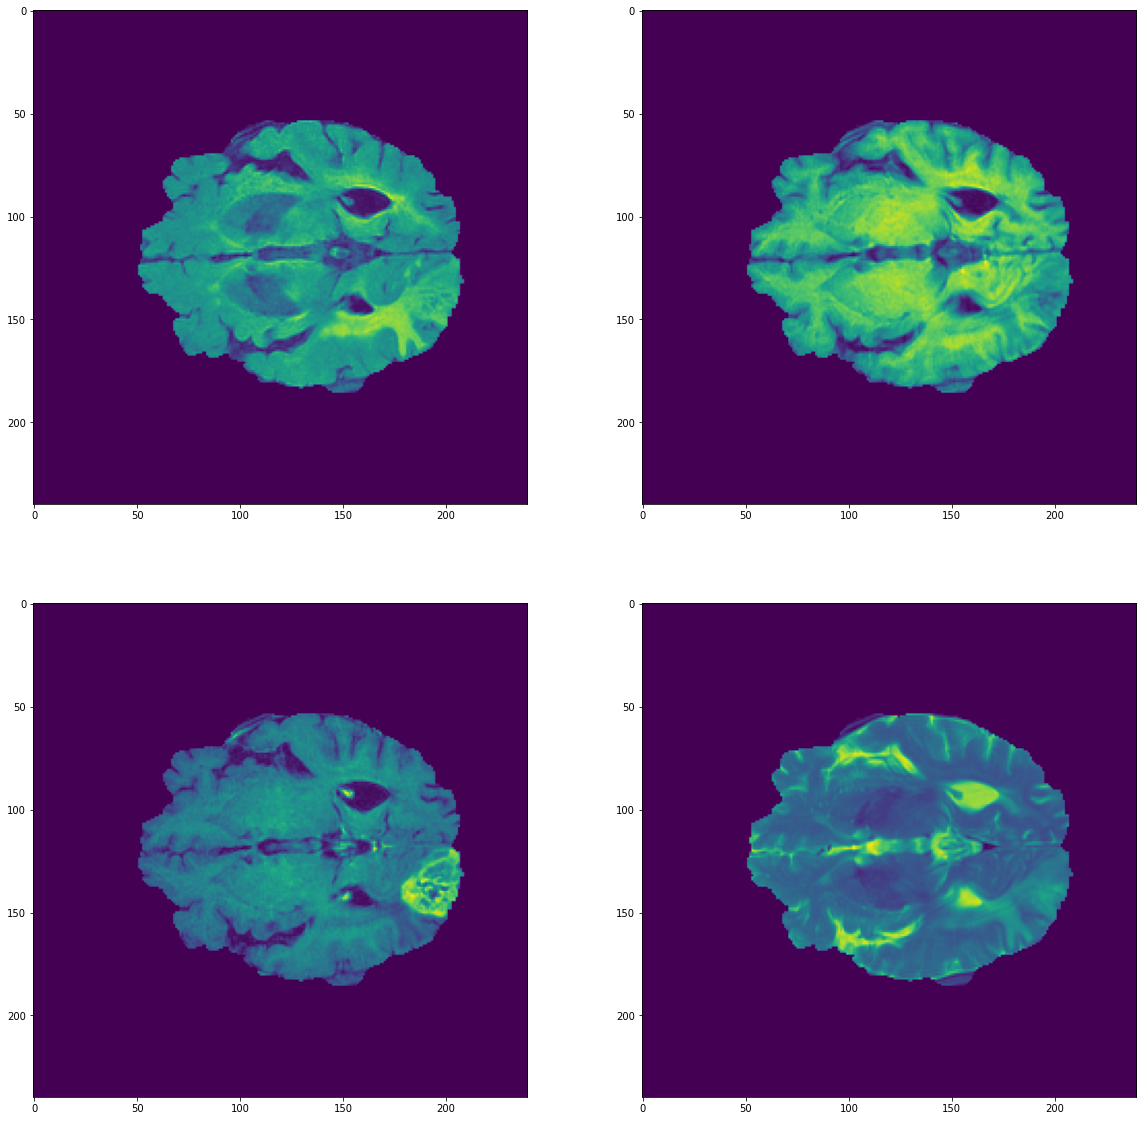

In [ ]:
f, axarr = plt.subplots(2,2, figsize=(20, 20))
for i in range(2):
    for j in range(2):
        axarr[i][j].imshow(to_plot_input[i*2 + j])

GROUND TRUTH : plot di whole tumor (WT), tumor core (TC) e enhancing tumor (ET)

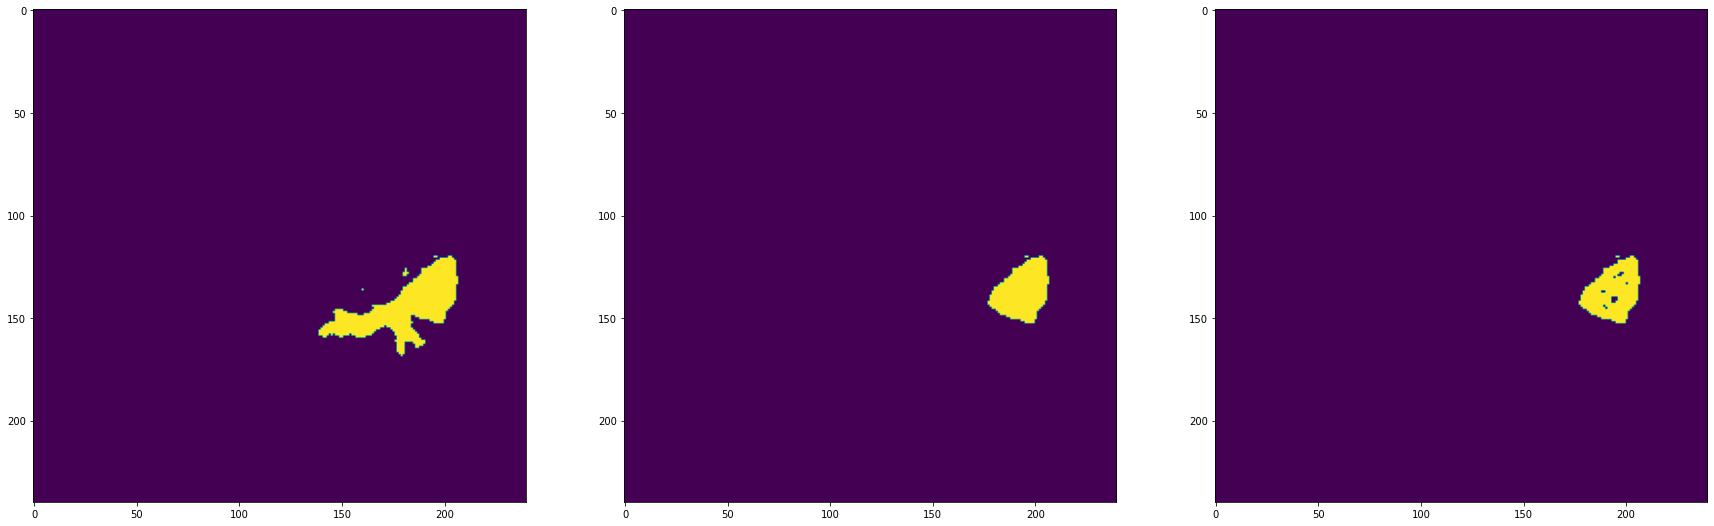

In [ ]:
f, axarr = plt.subplots(1,3, figsize=(30, 30))
for i in range(3):
    axarr[i].imshow(to_plot_truth[i])

OUTPUT del modello

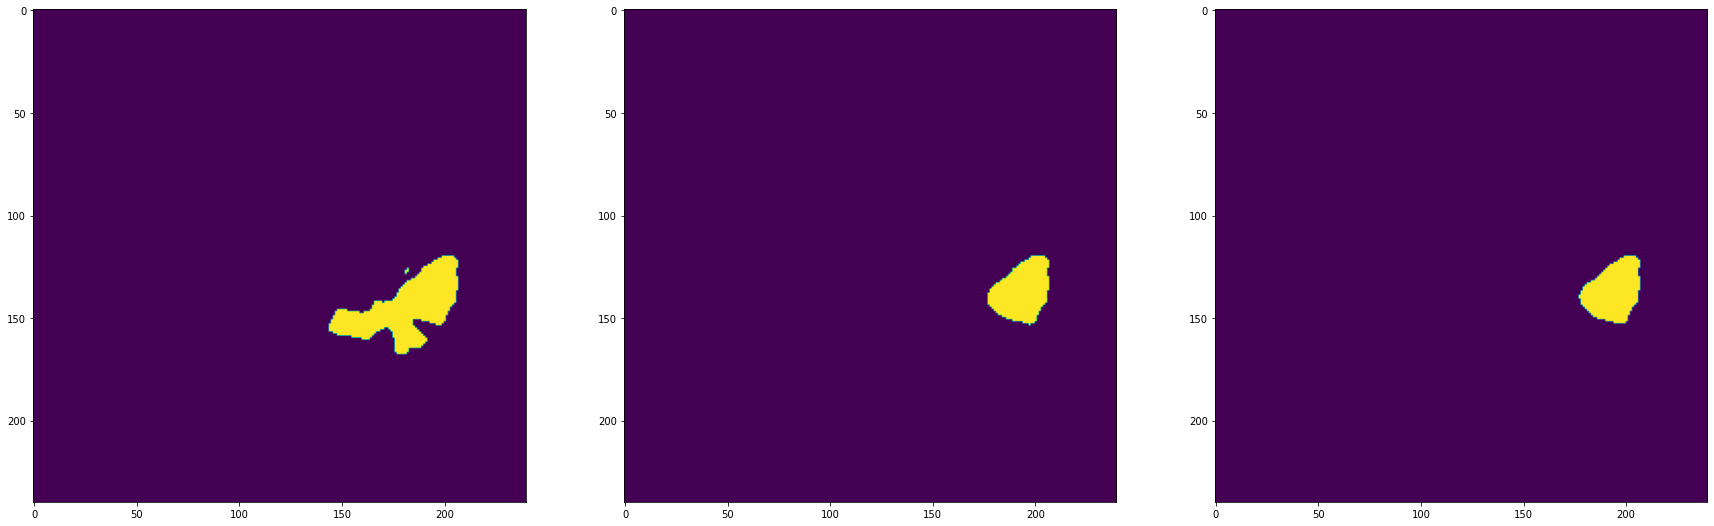

In [ ]:
f, axarr = plt.subplots(1,3, figsize=(30, 30))
for i in range(3):
    axarr[i].imshow(to_plot_output[i])

# Test delle metriche di Dice e Jaccard sulle tre categorie sul validation set

In [ ]:
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calcola il Jaccard index per un batch di data points.
    Parametri :
        prababilities: output del modello dopo activation function
        treshold : soglia oltre la quale la segmentazione passa da 0 a 1
        truth : immagine di ground truth per paragonare la segmentazione a target result
        eps : appprossimazione output alla nona cifra decimale (optional)
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calcola il Jaccard index per un batch di data points.
    Parametri :
        prababilities: output del modello dopo activation function
        treshold : soglia oltre la quale la segmentazione passa da 0 a 1
        truth : immagine di ground truth per paragonare la segmentazione a target result
        eps : appprossimazione output alla nona cifra decimale (optional)
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

def compute_scores_per_classes(model,
                               dataloader,
                               classes):
    """

    Calcola Dice e Jaccard per ogni classe di segmentazione
    Parametri :
        model : modello di rete neurale utilizzato (pretrained)
        dataloader : dataloader di validazione filtrato con datapoint dove è presente un tumore
        classes : array di etichette delle classi di segmentazione
        
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
          
            imgs, targets, level = data['image'], data['mask'], data['level']
            
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            
            logits = logits[:,:,:,:,level]
            targets = targets[:,:,:,:,level]
            
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            
            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes

dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    net, val_dl, ['WT', 'TC', 'ET']
    )

In [ ]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard', 
                                      'TC dice', 'TC jaccard', 
                                      'ET dice', 'ET jaccard']]

In [ ]:
val_metics_df.to_csv('metrics.csv')